<a href="https://colab.research.google.com/github/leokan92/class/blob/main/Aula4_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Aula 4 - **Transformers**

## Visualizando os outputs de cada parte do mecanismo de atenção

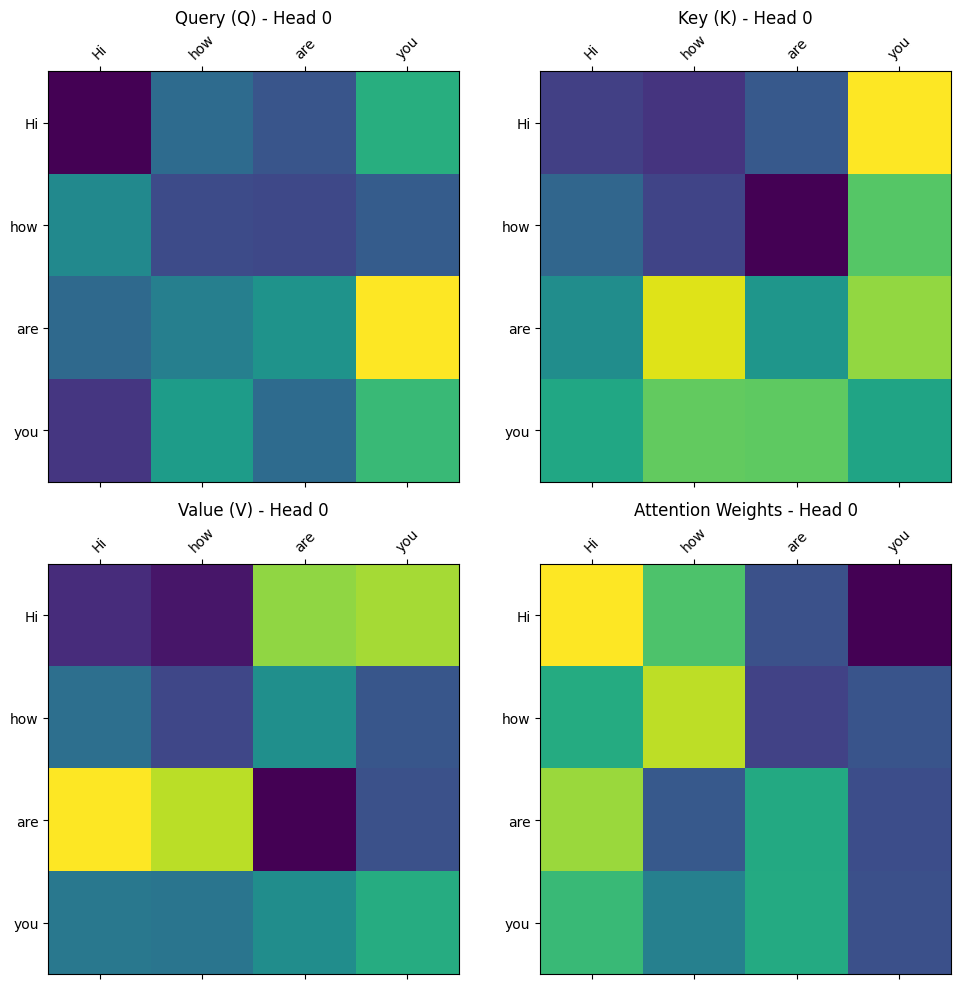

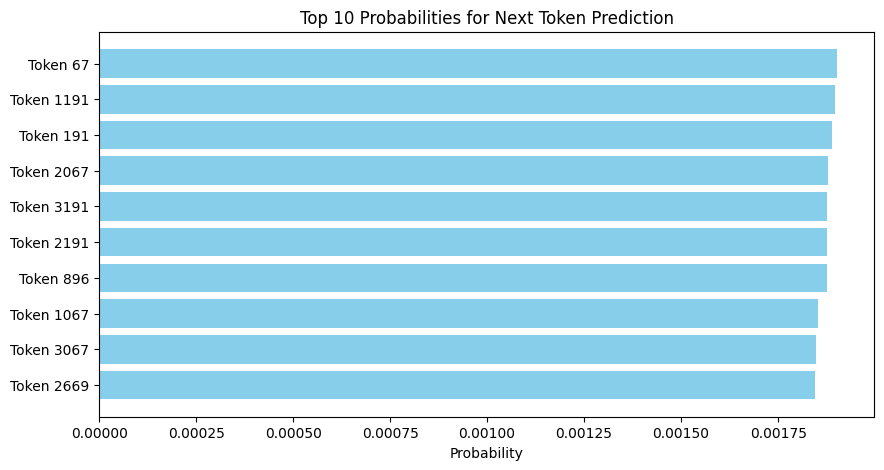

Output after attention: tensor([[-0.0135,  0.2527,  0.5382, -0.2539, -0.0304,  0.2101, -0.4374, -0.0654],
        [-0.0087,  0.2672,  0.5020, -0.2555, -0.0692,  0.1948, -0.4228, -0.0734],
        [-0.0469,  0.2454,  0.4666, -0.2619, -0.1134,  0.2080, -0.4477, -0.1623],
        [-0.0351,  0.2505,  0.4421, -0.2615, -0.1340,  0.1888, -0.4449, -0.1652]],
       grad_fn=<AddmmBackward0>)
Probabilities for next token: tensor([[0.0012, 0.0006, 0.0012,  ..., 0.0012, 0.0012, 0.0006],
        [0.0012, 0.0007, 0.0012,  ..., 0.0011, 0.0012, 0.0006],
        [0.0012, 0.0007, 0.0012,  ..., 0.0011, 0.0012, 0.0006],
        [0.0012, 0.0007, 0.0012,  ..., 0.0011, 0.0012, 0.0006]],
       grad_fn=<SoftmaxBackward0>)


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the Transformer configuration
d_model = 8  # Dimensionality of the embedding space (for simplicity)
n_heads = 2  # Number of attention heads
seq_length = 4  # Length of the sequence (e.g., "Hi how are you" has 4 tokens)
vocab_size = 1000  # Arbitrary vocabulary size

# Tokenize the input sequence (for simplicity, we use random token IDs)
tokens = torch.tensor([34, 67, 25, 89])  # Assume these are token IDs for "Hi", "how", "are", "you"

# Define embeddings for input tokens
embedding = nn.Embedding(vocab_size, d_model)
embedded_tokens = embedding(tokens)  # Shape: [seq_length, d_model]

# Define a Multi-Head Attention Layer to get Q, K, and V matrices
class SimpleMultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(SimpleMultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        # Define linear layers for Q, K, V
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        # Output linear layer
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size = x.size(0)

        # Generate Q, K, V matrices
        Q = self.q_linear(x)
        K = self.k_linear(x)
        V = self.v_linear(x)

        # Split into multiple heads and reshape
        Q = Q.view(batch_size, self.n_heads, self.d_k).transpose(0, 1)  # Shape: [n_heads, seq_length, d_k]
        K = K.view(batch_size, self.n_heads, self.d_k).transpose(0, 1)  # Shape: [n_heads, seq_length, d_k]
        V = V.view(batch_size, self.n_heads, self.d_k).transpose(0, 1)  # Shape: [n_heads, seq_length, d_k]

        # Calculate attention scores and apply to V
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        attention_weights = torch.nn.functional.softmax(scores, dim=-1)
        attended_values = torch.matmul(attention_weights, V)

        # Reshape to combine heads and pass through the output layer
        attended_values = attended_values.transpose(0, 1).contiguous().view(batch_size, -1)
        output = self.out(attended_values)

        return Q, K, V, attention_weights, output

# Define Decoder Layer
class SimpleDecoder(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(SimpleDecoder, self).__init__()
        self.linear = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        logits = self.linear(x)
        probs = torch.nn.functional.softmax(logits, dim=-1)
        return probs

# Instantiate and run the multi-head attention
multi_head_attention = SimpleMultiHeadAttention(d_model, n_heads)
Q, K, V, attention_weights, encoder_output = multi_head_attention(embedded_tokens)

# Instantiate the decoder
decoder = SimpleDecoder(d_model, vocab_size)

# Get probability distribution for the next token
probs = decoder(encoder_output)

# Define function to visualize probabilities for the next token
def plot_probabilities(probs, seq_tokens):
    # Flatten probs to ensure it's 1D
    probs = probs.view(-1)

    # Get top 10 probabilities and corresponding indices
    top_probs, top_indices = torch.topk(probs, 10)  # Get top 10 probabilities
    top_probs = top_probs.detach().cpu().numpy()  # Convert to numpy array
    top_indices = top_indices.detach().cpu().numpy()  # Convert to numpy array

    # Convert indices to a list of token names for visualization
    top_tokens = [f"Token {int(idx)}" for idx in top_indices]

    # Plot the top probabilities
    plt.figure(figsize=(10, 5))
    plt.barh(top_tokens, top_probs, color="skyblue")
    plt.xlabel("Probability")
    plt.title("Top 10 Probabilities for Next Token Prediction")
    plt.gca().invert_yaxis()
    plt.show()

# Define the input tokens for display
seq_tokens = ["Hi", "how", "are", "you"]

# Plot the Q, K, V, and attention weights
def plot_attention_matrices(Q, K, V, attention_weights, seq_tokens):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Plot Q, K, V for one head
    head = 0  # Choose head 0 to visualize
    for i, matrix in enumerate([Q[head], K[head], V[head]]):
        ax = axs[i//2, i%2]
        ax.matshow(matrix.detach().numpy(), cmap="viridis")
        ax.set_title(["Query (Q)", "Key (K)", "Value (V)"][i] + f" - Head {head}")
        ax.set_xticks(range(len(seq_tokens)))
        ax.set_xticklabels(seq_tokens, rotation=45)
        ax.set_yticks(range(len(seq_tokens)))
        ax.set_yticklabels(seq_tokens)

    # Plot attention weights
    ax = axs[1, 1]
    ax.matshow(attention_weights[head].detach().numpy(), cmap="viridis")
    ax.set_title("Attention Weights - Head 0")
    ax.set_xticks(range(len(seq_tokens)))
    ax.set_xticklabels(seq_tokens, rotation=45)
    ax.set_yticks(range(len(seq_tokens)))
    ax.set_yticklabels(seq_tokens)

    plt.tight_layout()
    plt.show()

# Define the input tokens for display
seq_tokens = ["Hi", "how", "are", "you"]

# Plot Q, K, V, and attention weights
plot_attention_matrices(Q, K, V, attention_weights, seq_tokens)

# Plot the probability distribution for the next token prediction
plot_probabilities(probs, seq_tokens)

print("Output after attention:", encoder_output)
print("Probabilities for next token:", probs)


##Treinando em uma base de dados de texto

In [ ]:
# Implementação de Andrej Karpathy
# Verifiquem o canale dele para mais detalhes da implementação: https://www.youtube.com/@AndrejKarpathy

import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ------------

In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=a4ab9ab2e8c2c5cd456a0019506fdff4f6e007c6904aae9cd35a869a8d844278
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
torch.manual_seed(1337)
import os
import wget
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

if not os.path.exists('input.txt'):
    wget.download('https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt')

with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [ ]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [ ]:
model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

10.788929 M parameters
step 0: train loss 4.2221, val loss 4.2306
step 500: train loss 1.7600, val loss 1.9146
step 1000: train loss 1.3903, val loss 1.5987
step 1500: train loss 1.2644, val loss 1.5271
step 2000: train loss 1.1835, val loss 1.4978
step 2500: train loss 1.1233, val loss 1.4910
step 3000: train loss 1.0718, val loss 1.4804
step 3500: train loss 1.0179, val loss 1.5127
step 4000: train loss 0.9604, val loss 1.5102
step 4500: train loss 0.9125, val loss 1.5351
step 4999: train loss 0.8589, val loss 1.5565

But with prison, I will steal for the fimker.

KING HENRY VI:
To prevent it, as I love this country's cause.

HENRY BOLINGBROKE:
I thank bhop my follow. Walk ye were so?

NORTHUMBERLAND:
My lord, I hearison! Who may love me accurse
Some chold or flights then men shows to great the cur
Ye cause who fled the trick that did princely action?
Take my captiving sound, althoughts thy crown.

RICHMOND NE:
God neit will he not make it wise this!

DUKE VINCENTIO:
Worthy Prince fo